In [1]:
# 16/06/2020
# TASI.AI
# Raphael Mourad

# ARIMA + Exogenous variables = ARIMAX
# ARIMAX is an ARIMA model but in which you can include additional features 
# such as option features to better predict the price.

# https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

###### IMPORT LIBRARIES AND SET UP PARAMETERS

# Import libraries
import os
import pandas as pd
import numpy as np
import sklearn.metrics as mt
import random
import datetime
from pandas_datareader import DataReader
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from scipy.stats import norm

/home/mourad/.local/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Set up directory
dir="/media/mourad/diskSave/MCF_Toulouse/recherche/ConsulProj/TASI.AI_RamCiri"
os.chdir(dir)
print(os.getcwd())

/media/mourad/diskSave/MCF_Toulouse/recherche/ConsulProj/TASI.AI_RamCiri


In [3]:
# Parameters
symbol="GOOG" # Set up the symbol you want
kdays=30 # Number of days for forecasting
kdaysExpi=90 # Number of days until expiration date

In [4]:
# Create folder for symbol
symbolFolder="results/ARIMA_optionstats_features/"+symbol
if(os.path.isdir(symbolFolder)==False):
    os.mkdir(symbolFolder, mode=0o777)

In [5]:
###### LOAD AND PREPROCESS DATA

### STOCK PRICE
# Import price
path="data/stockquotes/samples_L3_stockquotes_sample.csv.gz"
data_stockquotes = pd.read_csv(path, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
data_stockquotes["quotedate"] = pd.to_datetime(data_stockquotes["quotedate"])
#print(data_stockquotes)
print(np.unique(data_stockquotes["symbol"]))

# Choose the stock
data_stockquotes_sel=data_stockquotes[data_stockquotes["symbol"]==symbol]
data_stockquotes_sel=data_stockquotes_sel.sort_values('quotedate')
data_stockquotes_sel=data_stockquotes_sel[["symbol","quotedate","close"]]
#data_stockquotes_sel=data_stockquotes_sel.set_index('quotedate')
print(data_stockquotes_sel)

# Check the absence of missing data 
NAcount=data_stockquotes.isnull().sum().sum()
print("Missing data=",NAcount)

['AAPL' 'AMZN' 'AXP' 'BA' 'CAT' 'CDLX' 'CHGG' 'CYBR' 'DIS' 'EROS' 'EVER'
 'GOOG' 'GS' 'HD' 'IBM' 'ITRI' 'JNJ' 'JPM' 'KO' 'MCD' 'MRK' 'MSFT' 'NFLX'
 'NIO' 'NKE' 'OSIS' 'PFE' 'PG' 'PRFT' 'XOM']
      symbol  quotedate        close
28392   GOOG 2015-05-01   537.900024
29216   GOOG 2015-05-04   540.780029
28720   GOOG 2015-05-05   530.799988
28412   GOOG 2015-05-06   524.219971
27995   GOOG 2015-05-07   530.700012
...      ...        ...          ...
28666   GOOG 2020-05-22  1410.420000
28255   GOOG 2020-05-26  1417.020000
28923   GOOG 2020-05-27  1417.840000
28256   GOOG 2020-05-28  1416.730000
29272   GOOG 2020-05-29  1428.920000

[1278 rows x 3 columns]
Missing data= 0


In [6]:
### STOCK OPTION STATISTICS
# Import optionstats
pathOptionStats="data/optionstats/samples_L3_optionstats_sample.csv.gz"
data_optionStats = pd.read_csv(pathOptionStats, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
data_optionStats["quotedate"] = pd.to_datetime(data_optionStats["quotedate"])
data_optionStats = data_optionStats.drop(columns=["iv30put","iv30mean","iv60put","iv60mean","iv90put","iv90mean",
                                                 "iv120put","iv120mean","iv150put","iv150mean","iv180put","iv180mean",
                                                 "iv360put","iv360mean"])
print(data_optionStats.columns.values)

# Choose the stock
data_optionStats_sel=data_optionStats[data_optionStats["symbol"]==symbol]
data_optionStats_sel=data_optionStats_sel.sort_values(["quotedate"])
#data_optionStats_sel=data_optionStats_sel.set_index('quotedate')
data_optionStats_sel=pd.DataFrame.drop_duplicates(data_optionStats_sel)
data_optionStats_sel=data_optionStats_sel.drop(columns=["symbol"])
#print(data_optionStats_sel)

# Compute new features from optionstats
# 1 is added to avoid +Inf values
# Call volume / total volume ratio (CTVR)
data_optionStats_sel["CTVR"]=(data_optionStats_sel["callvol"]+1)/(data_optionStats_sel["totalvol"]+1)
# Call oi / total oi ratio (CToiR)
data_optionStats_sel["CToiR"]=(data_optionStats_sel["calloi"]+1)/(data_optionStats_sel["totaloi"]+1)
# Total oi / Total volume ratio (ToiTVR)
data_optionStats_sel["ToiTVR"]=(data_optionStats_sel["totaloi"]+1)/(data_optionStats_sel["totalvol"]+1)
# Current volume / Previous day oi
TVday1=data_optionStats_sel.iloc[1:len(data_optionStats_sel),data_optionStats_sel.columns.values=="totalvol"]
Toiday0=data_optionStats_sel.iloc[0:(len(data_optionStats_sel)-1),data_optionStats_sel.columns.values=="totaloi"]
CVPoi=(TVday1["totalvol"].values+1)/(Toiday0["totaloi"].values+1)
CVPoi=np.append(CVPoi[0],CVPoi)
data_optionStats_sel["CVPoi"]=CVPoi
print(data_optionStats_sel[["iv30call","iv60call",'totalvol','totaloi','CVPoi']])

['symbol' 'quotedate' 'iv30call' 'iv60call' 'iv90call' 'iv120call'
 'iv150call' 'iv180call' 'iv360call' 'callvol' 'putvol' 'totalvol'
 'calloi' 'putoi' 'totaloi']
       iv30call  iv60call  totalvol  totaloi     CVPoi
254      0.2106    0.2036     19921    50315  0.359766
45682    0.2089    0.2044     18101    48410  0.359766
14935    0.2205    0.2147     22541    57643  0.465638
34595    0.2121    0.2154     19145    71344  0.332142
23729    0.2114    0.2068     17644    78041  0.247319
...         ...       ...       ...      ...       ...
29009    0.2622    0.2734     21558   145649  0.150683
62318    0.2629    0.2741     24197   135275  0.166138
38948    0.2646    0.2793     14073   144224  0.104039
9640     0.2701    0.2840     19518   145736  0.135337
14270    0.2629    0.2740     24317   149642  0.166862

[1114 rows x 5 columns]


In [7]:
### STOCK OPTION FEATURES
# Import option_features
pathOptionFeats="data/options_features/samples_L3_options_features_"+symbol+"_"+str(kdaysExpi)+"daysExpi.csv.gz"
data_optionFeats = pd.read_csv(pathOptionFeats, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
print(data_optionFeats)
data_optionFeats["DataDate"] = pd.to_datetime(data_optionFeats["DataDate"])

        DataDate    PCR      SM      SWM      WMEP  MROI    WMD    WMG  \
0     2015-05-01  1.461  24.890   29.337   513.368   0.0 -0.083  0.008   
1     2015-05-04  0.706  23.280   33.616   555.014   0.0  0.128  0.008   
2     2015-05-05  1.185  23.100   26.606   518.185   0.0 -0.106  0.009   
3     2015-05-06  1.875  21.720   25.949   510.224   0.0 -0.145  0.009   
4     2015-05-07  0.882  22.200   24.745   539.700   0.0  0.063  0.009   
...          ...    ...     ...      ...       ...   ...    ...    ...   
1273  2020-05-22  0.525  52.075   61.256  1461.020   0.0  0.440  0.003   
1274  2020-05-26  1.878  58.325  102.999  1317.926   0.0 -0.205  0.002   
1275  2020-05-27  0.760  58.350  100.710  1437.675   0.0  0.111  0.002   
1276  2020-05-28  0.661  61.000   82.162  1470.973   0.0  0.296  0.003   
1277  2020-05-29  1.850  58.080   91.390  1376.608   0.0 -0.188  0.002   

          WMT      WMV  
0     -47.717   63.399  
1     -43.834   57.466  
2     -51.684   59.622  
3     -53.6

In [8]:
### MERGE PRICE WITH OPTION STATS AND OPTION FEATS

# Merge price with option stats
priceOptionStats=data_stockquotes_sel.merge(data_optionStats_sel, left_on='quotedate', right_on='quotedate')

# Merge with option feats
priceOptionStatsFeats=priceOptionStats.merge(data_optionFeats, left_on='quotedate', right_on='DataDate')

# Format table
priceOptionStatsFeats=priceOptionStatsFeats.drop(columns=["symbol","DataDate"])
priceOptionStatsFeats=priceOptionStatsFeats.set_index('quotedate')
#print(priceOptionStats[["close","iv30call","iv30put"]])
print(priceOptionStatsFeats)

                  close  iv30call  iv60call  iv90call  iv120call  iv150call  \
quotedate                                                                     
2015-05-01   537.900024    0.2106    0.2036    0.2057     0.1971     0.1952   
2015-05-04   540.780029    0.2089    0.2044    0.2040     0.2014     0.2035   
2015-05-05   530.799988    0.2205    0.2147    0.2122     0.2071     0.2082   
2015-05-06   524.219971    0.2121    0.2154    0.2124     0.2072     0.2086   
2015-05-07   530.700012    0.2114    0.2068    0.2098     0.2054     0.2079   
...                 ...       ...       ...       ...        ...        ...   
2020-05-22  1410.420000    0.2622    0.2734    0.2987     0.2946     0.3019   
2020-05-26  1417.020000    0.2629    0.2741    0.2987     0.2973     0.3034   
2020-05-27  1417.840000    0.2646    0.2793    0.2985     0.2956     0.3032   
2020-05-28  1416.730000    0.2701    0.2840    0.3027     0.2998     0.3064   
2020-05-29  1428.920000    0.2629    0.2740    0.299

In [9]:
###### BUILD AND AUTOSELECT ARIMA MODEL

# Split train/test data
priceOptionStatsTrain = priceOptionStatsFeats[0:(len(priceOptionStatsFeats)-kdays)]
priceOptionStatsTest = priceOptionStatsFeats[(len(priceOptionStatsFeats)-kdays):len(priceOptionStatsFeats)]

priceCloseTrain=priceOptionStatsTrain["close"]
priceCloseTest=priceOptionStatsTest["close"]

exogenousTrain=priceOptionStatsTrain.drop(columns="close")
exogenousTest=priceOptionStatsTest.drop(columns="close")
#print(priceOptionStatsTrain)
#print(priceOptionStatsTest[0:5])

In [10]:
# Build ARIMA model and finding automatically the best ARIMA model (function called auto_arima)
autoARIMA = auto_arima(priceCloseTrain, seasonal=False, trace=True,
                error_action='ignore', suppress_warnings=True, stepwise=True)
ARIMAbestparams=autoARIMA.order
print(ARIMAbestparams)
file_autoARIMA = open(symbolFolder+"/autoARIMA_"+symbol+".txt", "a")
file_autoARIMA.write(str(autoARIMA.summary()))
file_autoARIMA.close()

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=9165.698, BIC=9195.612, Time=0.575 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=9192.154, BIC=9202.125, Time=0.019 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=9163.267, BIC=9178.224, Time=0.046 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=9165.394, BIC=9180.351, Time=0.124 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=9191.845, BIC=9196.831, Time=0.015 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=9164.937, BIC=9184.880, Time=0.138 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=9165.053, BIC=9184.996, Time=0.217 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=9166.115, BIC=9191.044, Time=0.709 seconds
Total fit time: 1.859 seconds
(1, 1, 0)


In [11]:
# Ranking of exogenous features one by one using AIC
# The higher the loss the better the feature
print("No exo: \tAIC="+str(round(autoARIMA.aic())))

exogenousVars=exogenousTrain.columns.values
AICVars=list()
for k in range(0, len(exogenousVars)):
    vark=exogenousVars[k]
    ARIMAi=auto_arima(priceCloseTrain, exogenous=pd.DataFrame(exogenousTrain[vark]), 
            seasonal=False, trace=False, error_action='ignore', suppress_warnings=True, stepwise=True,
            start_p=ARIMAbestparams[0], d=ARIMAbestparams[1], start_q=ARIMAbestparams[2], 
            max_p=ARIMAbestparams[0], max_d=ARIMAbestparams[1], max_q=ARIMAbestparams[2])
    AICVars.append(ARIMAi.aic())
    print(vark+": \tAIC="+str(round(ARIMAi.aic()))+"\tdiffAIC=",str(round(autoARIMA.aic()-ARIMAi.aic())))

# Save results
matAIC=pd.DataFrame()
matAIC["ExoVar"]=exogenousVars
matAIC["AIC"]=AICVars
matAIC["DiffAIC"]=autoARIMA.aic()-AICVars
matAIC["PercentGainAIC"]=(autoARIMA.aic()-AICVars)/autoARIMA.aic()
pathMatAIC=symbolFolder+"/matrix_ARIMAX_AIC_exogenousVars_"+symbol+".csv"
matAIC.to_csv(pathMatAIC, index=False, sep=',', quotechar='"')

No exo: 	AIC=9163
iv30call: 	AIC=8862	diffAIC= 301
iv60call: 	AIC=8868	diffAIC= 296
iv90call: 	AIC=8947	diffAIC= 216
iv120call: 	AIC=8960	diffAIC= 203
iv150call: 	AIC=8979	diffAIC= 184
iv180call: 	AIC=9007	diffAIC= 156
iv360call: 	AIC=9095	diffAIC= 68
callvol: 	AIC=9143	diffAIC= 20
putvol: 	AIC=9157	diffAIC= 6
totalvol: 	AIC=9148	diffAIC= 15
calloi: 	AIC=9165	diffAIC= -1
putoi: 	AIC=9165	diffAIC= -2
totaloi: 	AIC=9165	diffAIC= -2
CTVR: 	AIC=9158	diffAIC= 5
CToiR: 	AIC=9164	diffAIC= -1
ToiTVR: 	AIC=9159	diffAIC= 4
CVPoi: 	AIC=9145	diffAIC= 18
PCR: 	AIC=9164	diffAIC= -1
SM: 	AIC=8996	diffAIC= 168
SWM: 	AIC=9148	diffAIC= 16
WMEP: 	AIC=9089	diffAIC= 74
MROI: 	AIC=9165	diffAIC= -2
WMD: 	AIC=9151	diffAIC= 12
WMG: 	AIC=9164	diffAIC= -1
WMT: 	AIC=9164	diffAIC= -1
WMV: 	AIC=9150	diffAIC= 13


In [12]:
###### Assess combination of exogenous variables to find the best combination

# List of best exogenous variable candidates
zippedVarSel=zip(matAIC["DiffAIC"],exogenousVars)
exoVarSelected = [element for _, element in sorted(zippedVarSel,reverse=True)]
#print(exoVarSelected)

# ARIMA with exogenous variables
ARIMAexolist=list()
AICVarsList=list()
exolist=list()
for k in range(0, len(exoVarSelected)):
    ARIMAexoi=auto_arima(priceCloseTrain, exogenous=pd.DataFrame(exogenousTrain[exoVarSelected[0:(k+1)]]), seasonal=False, trace=False,
            error_action='ignore', suppress_warnings=True, stepwise=True,
            start_p=ARIMAbestparams[0], d=ARIMAbestparams[1], start_q=ARIMAbestparams[2], 
            max_p=ARIMAbestparams[0], max_d=ARIMAbestparams[1], max_q=ARIMAbestparams[2])
    ARIMAexolist.append(ARIMAexoi)
    AICVarsList.append(ARIMAexoi.aic())
    exolist.append('_'.join(exoVarSelected[0:(k+1)]))
    print("Exo "+str(exoVarSelected[0:(k+1)])+": \tAIC="+str(round(ARIMAexoi.aic()))+"\tdiffAIC="+str(round(autoARIMA.aic()-ARIMAexoi.aic())))
    
# Save results
matAICExoList=pd.DataFrame()
matAICExoList["ExoVarList"]=exolist
matAICExoList["AIC"]=AICVarsList
matAICExoList["DiffAIC"]=autoARIMA.aic()-AICVarsList
matAICExoList["PercentGainAIC"]=(autoARIMA.aic()-AICVarsList)/autoARIMA.aic()
pathMatAICExoList=symbolFolder+"/matrix_ARIMAX_AIC_exogenousVarsList_"+symbol+".csv"
matAICExoList.to_csv(pathMatAICExoList, index=False, sep=',', quotechar='"')

Exo ['iv30call']: 	AIC=8862	diffAIC=301
Exo ['iv30call', 'iv60call']: 	AIC=8849	diffAIC=315
Exo ['iv30call', 'iv60call', 'iv90call']: 	AIC=8850	diffAIC=314
Exo ['iv30call', 'iv60call', 'iv90call', 'iv120call']: 	AIC=8844	diffAIC=319
Exo ['iv30call', 'iv60call', 'iv90call', 'iv120call', 'iv150call']: 	AIC=8844	diffAIC=319
Exo ['iv30call', 'iv60call', 'iv90call', 'iv120call', 'iv150call', 'SM']: 	AIC=8841	diffAIC=322
Exo ['iv30call', 'iv60call', 'iv90call', 'iv120call', 'iv150call', 'SM', 'iv180call']: 	AIC=8835	diffAIC=329
Exo ['iv30call', 'iv60call', 'iv90call', 'iv120call', 'iv150call', 'SM', 'iv180call', 'WMEP']: 	AIC=8761	diffAIC=402
Exo ['iv30call', 'iv60call', 'iv90call', 'iv120call', 'iv150call', 'SM', 'iv180call', 'WMEP', 'iv360call']: 	AIC=8671	diffAIC=492
Exo ['iv30call', 'iv60call', 'iv90call', 'iv120call', 'iv150call', 'SM', 'iv180call', 'WMEP', 'iv360call', 'callvol']: 	AIC=8660	diffAIC=503
Exo ['iv30call', 'iv60call', 'iv90call', 'iv120call', 'iv150call', 'SM', 'iv180call'

In [13]:
###### FORECAST AVERAGE PRICE USING ARIMA MODEL

# Forecast with no exogenous variable (for comparison)
future_forecast_noexo = autoARIMA.predict(n_periods=kdays)

# Forecast for all exogenous variables with ARIMA 
# A ARIMA model is built to predict each exogenous variable.
future_forecast_forexo=pd.DataFrame()
for var in exoVarSelected:
    autoARIMAforexoi = auto_arima(exogenousTrain[var], seasonal=False, trace=False,
                error_action='ignore', suppress_warnings=True, stepwise=True)
    future_forecast_forexoi=pd.DataFrame(autoARIMAforexoi.predict(n_periods=kdays))
    future_forecast_forexo=pd.concat([future_forecast_forexo, future_forecast_forexoi], axis=1)
future_forecast_forexo.columns=exoVarSelected
future_forecast_forexo.index=priceCloseTest.index

In [23]:
# Forecast using ARIMA with exogenous variables
RMSEnoexo=np.sqrt(mt.mean_squared_error(priceCloseTest, future_forecast_noexo))
MAEnoexo=mt.mean_absolute_error(priceCloseTest, future_forecast_noexo)

RMSElist=[None] * len(exoVarSelected)
MAElist=[None] * len(exoVarSelected)
ExoVarList=[None] * len(exoVarSelected)
future_forecast_exo_List=[None] * len(exoVarSelected)
conf_int_exo_List=[None] * len(exoVarSelected)
for k in range(0, len(exoVarSelected)):
    future_forecast_exoi, conf_int_exoi = ARIMAexolist[k].predict(n_periods=kdays, return_conf_int=True,alpha=0.05,
                                exogenous=pd.DataFrame(future_forecast_forexo[exoVarSelected[0:(k+1)]],index=future_forecast_forexo.index))
    RMSEi=np.sqrt(mt.mean_squared_error(priceCloseTest, future_forecast_exoi))
    RMSElist[k]=RMSEi
    MAEi=mt.mean_absolute_error(priceCloseTest, future_forecast_exoi)
    MAElist[k]=MAEi
    ExoVarList[k]='_'.join(exoVarSelected[0:(k+1)])
    future_forecast_exo_List[k]=future_forecast_exoi
    conf_int_exo_List[k]=conf_int_exoi
    #print(str(exoVarSelected[0:(k+1)]))

/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/mourad/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: Value

In [16]:
# Best models
print("RMSE_noexo: "+str(round(RMSEnoexo,3))+"\tMAE_noexo: "+str(round(MAEnoexo,3))+"\n")

matMetrics=pd.DataFrame()
matMetrics["ExoVar"]=ExoVarList
matMetrics["RMSE"]=np.round(RMSElist,2)
matMetrics["MAE"]=np.round(MAElist,2)
matMetrics["RMSEPercentReduction"]=np.round((RMSElist-RMSEnoexo)/RMSEnoexo,2)
matMetrics["MAEPercentReduction"]=np.round((MAElist-MAEnoexo)/MAEnoexo,2)
print(matMetrics)
print("\nBest model: "+ExoVarList[np.argmin(RMSElist)])

pathMatMetrics=symbolFolder+"/matrix_ARIMAX_metrics_exogenousVarsList_"+symbol+".csv"
matMetrics.to_csv(pathMatMetrics, index=False, sep=',', quotechar='"')

RMSE_noexo: 90.778	MAE_noexo: 78.899

                                               ExoVar   RMSE    MAE  \
0                                            iv30call  88.83  77.00   
1                                   iv30call_iv60call  88.61  76.81   
2                          iv30call_iv60call_iv90call  88.58  76.78   
3                iv30call_iv60call_iv90call_iv120call  86.74  75.11   
4      iv30call_iv60call_iv90call_iv120call_iv150call  88.26  76.49   
5   iv30call_iv60call_iv90call_iv120call_iv150call_SM  88.11  76.36   
6   iv30call_iv60call_iv90call_iv120call_iv150call...  87.58  75.85   
7   iv30call_iv60call_iv90call_iv120call_iv150call...  99.12  87.54   
8   iv30call_iv60call_iv90call_iv120call_iv150call...  97.86  86.22   
9   iv30call_iv60call_iv90call_iv120call_iv150call...  97.17  85.51   
10  iv30call_iv60call_iv90call_iv120call_iv150call...  97.26  85.60   
11  iv30call_iv60call_iv90call_iv120call_iv150call...  91.08  79.30   
12  iv30call_iv60call_iv90call_iv120cal

In [17]:
# Forecast with confidence interval (alpha=5%)
future_forecast_exobest=future_forecast_exo_List[np.argmin(RMSElist)]
conf_int_exobest=conf_int_exo_List[np.argmin(RMSElist)]

future_forecast = pd.DataFrame(future_forecast_exobest,columns=['future_forecast'],index=priceCloseTest.index.values)
priceCloseTest = pd.DataFrame(priceCloseTest)
conf_int=conf_int_exobest

model_exobest=ARIMAexolist[np.argmin(RMSElist)]
file_autoARIMAexobest = open(symbolFolder+"/autoARIMA_"+symbol+"_bestexo.txt", "a")
file_autoARIMAexobest.write(str(model_exobest.summary()))
file_autoARIMAexobest.close()

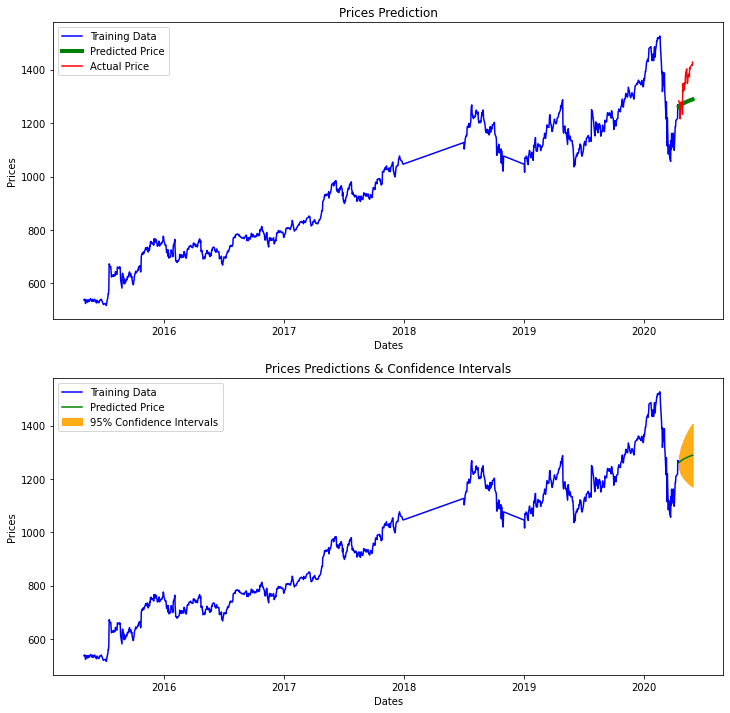

In [17]:
# Better forecast plots
plotForeCastBetter=symbolFolder+"/plot_ARIMA_forecast_better_"+symbol+".pdf"
fig, axes = pyplot.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(priceCloseTrain, color='blue', label='Training Data')
axes[0].plot(priceCloseTest.index, future_forecast, color='green', linewidth=4, label='Predicted Price')

axes[0].plot(priceCloseTest.index, priceCloseTest, color='red', label='Actual Price')
axes[0].set_title('Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(priceCloseTrain, color='blue', label='Training Data')
axes[1].plot(priceCloseTest.index, future_forecast, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(conf_int)
axes[1].fill_between(priceCloseTest.index, conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange', label="95% Confidence Intervals")
axes[1].legend()
pyplot.savefig(plotForeCastBetter, bbox_inches='tight')


mu=1289.011
SE=60.226


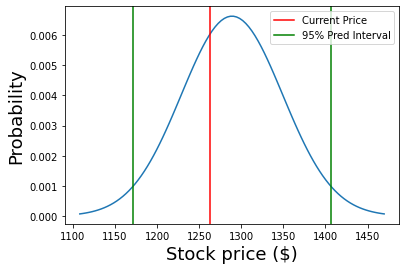

In [18]:
###### PROBABILITY GRAPH FROM ARIMA MODEL

# Note to Rim and Quinn: ARIMA model computes a predicted mean mu at kdays and a 95% confidence interval
# To compute the probability graph (AKA density function in statistics),
# we calculate the Standard Error (SE) from the lower bound of the confidence interval.
# Once we have the mean mu and the SE, then we can plot the probability graph.

# Current price
priceCloseCurrent=priceCloseTrain.iloc[len(priceCloseTrain)-1]

# Extract predicted mean and confidence interval
mu=future_forecast.iloc[kdays-1,0]
lower=conf_int[kdays-1,0]
upper=conf_int[kdays-1,1]
print("mu="+str(round(mu,3)))

# Compute Standard Error (SE) from predicted confidence interval (reverse engineering here ;) )
se=(mu-lower)/norm.ppf(0.975)
print("SE="+str(round(se,3)))

# Probability graph
plotProbabilityGraph=symbolFolder+"/plot_ARIMA_probabilityGraph_"+symbol+"_"+str(kdays)+"days.pdf"
x = np.linspace(mu - 3*se, mu + 3*se, 100)
pyplot.plot(x, norm.pdf(x, mu, se))
pyplot.axvline(x=priceCloseCurrent,color='red',label='Current Price')
pyplot.axvline(x=lower,color='green',label='95% Pred Interval')
pyplot.axvline(x=upper,color='green')
pyplot.xlabel('Stock price ($)', fontsize=18)
pyplot.ylabel('Probability', fontsize=18)
pyplot.legend(loc='upper right')
pyplot.savefig(plotProbabilityGraph, bbox_inches='tight')
pyplot.show()